In [1]:
import sys
import torch  
import numpy as np  
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from torch.distributions.categorical import Categorical
import math
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from preprocess import mean, std, preprocess_input_function
from settings import train_dir, test_dir, train_push_dir, train_batch_size, test_batch_size, train_push_batch_size
from settings import base_architecture, img_size, prototype_shape, num_classes, prototype_activation_function, add_on_layers_type
from receptive_field import compute_rf_prototype
import cv2
#from reward_model import construct_PrefNet, paired_cross_entropy_loss, PrefNet
from tqdm import tqdm
from settings import joint_optimizer_lrs, joint_lr_step_size
import skimage as sk
import skimage.io as skio
import train_and_test as tnt
from torch.utils.data import Subset
import time
import heapq

In [20]:
'''
Use PPnet's forward pass as the policy network (actor network); what about the network for value function (critic network)?
Since there are only determinant actions, this is essentially A2C...
'''
class A3C_PPnet(nn.Module):
    def __init__(self, PPnet, preference_model, k=1, p=5, learning_rate=1e-4, dummy_reward=False, train_batch_size=80):
        super(A3C_PPnet, self).__init__()
        
        
        self.PPnet = PPnet.cuda()
        self.k = k
        self.pf_model = preference_model.cuda()
        
        self.PPnet_multi = self.PPnet
        for p in self.PPnet_multi.module.features.parameters():
            p.requires_grad = False
        for p in self.PPnet_multi.module.add_on_layers.parameters():
            p.requires_grad = False
        self.PPnet_multi.module.prototype_vectors.requires_grad = True
        for p in self.PPnet_multi.module.last_layer.parameters():
            p.requires_grad = False
        
        self.train_batch_size = train_batch_size
        self.num_epoch = 0
        policy_optimizer_specs = [#{'params': self.PPnet.features.parameters(), 'lr': joint_optimizer_lrs['features'], 'weight_decay': 1e-3}, 
                                  #{'params': self.PPnet.add_on_layers.parameters(), 'lr': joint_optimizer_lrs['add_on_layers'], 'weight_decay': 1e-3},
                                  #{'params': self.PPnet.prototype_vectors, 'lr': joint_optimizer_lrs['prototype_vectors']},
                                  #{'params': self.PPnet.module.add_on_layers.parameters(), 'lr': 1e-4, 'weight_decay': 1e-5},
                                  {'params': self.PPnet.module.prototype_vectors, 'lr': 1e-3, 'weight_decay': 1e-4}
                                  ]
        self.policy_optimizer = torch.optim.Adam(policy_optimizer_specs)
        self.num_iteration = 0
        
        
    def get_heatmaps(self, batch_x, labels, pid):
        self.PPnet_multi.eval()
        n_prototypes = self.PPnet_multi.module.num_prototypes
        prototype_shape = self.PPnet_multi.module.prototype_shape
        max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
        protoL_rf_info = self.PPnet_multi.module.proto_layer_rf_info
        
        batch_x = batch_x.cuda()
        protoL_input_torch, proto_dist_torch = self.PPnet_multi.module.push_forward(batch_x)
        
        proto_dist_ = proto_dist_torch.view(proto_dist_torch.shape[0], proto_dist_torch.shape[1], -1)
        # proto_dist_: (batch_size, 1000, 49)
        all_distances = torch.amin(proto_dist_, axis=-1)
        # all_distances: (batch_size, 1000)
        target_p = [pid]
        #for i in range(all_distances.shape[1]):
        #    class_i = torch.argmax(self.PPnet_multi.module.prototype_class_identity[i])
        #    if class_i == class_identity:
        #        target_p.append(i)
        
        proto_dist = torch.clone(proto_dist_torch)
       
        proto_dist = torch.transpose(proto_dist, 0, 1)
        dists = all_distances[:, target_p]
        dists = torch.transpose(dists, 0, 1)
        
    
        # proto_dist: (1000, batch_size)
        proto_dist_numpy = proto_dist.detach().cpu().numpy()
        
        
        original_imgs = []
        rescaled_patterns = []
        
        for j in target_p:
            
            original_imgs_j = []
            rescaled_patterns_j = []
           
            for i in range(len(batch_x)):
                closest_patch_indices_in_distance_map_j = list(np.unravel_index(np.argmin(proto_dist_numpy[j][i],axis=None), proto_dist_numpy[j][i].shape))
                closest_patch_indices_in_distance_map_j = [0] + closest_patch_indices_in_distance_map_j
                
                closest_patch_indices_in_img = compute_rf_prototype(batch_x.size(2), closest_patch_indices_in_distance_map_j, protoL_rf_info)
                closest_patch = \
                    batch_x[i, :, closest_patch_indices_in_img[1]:closest_patch_indices_in_img[2], closest_patch_indices_in_img[3]:closest_patch_indices_in_img[4]]
                closest_patch = closest_patch.cpu().numpy()
                closest_patch = np.transpose(closest_patch, (1, 2, 0))

                original_img = batch_x[i].cpu().numpy()
                original_img = np.transpose(original_img, (1, 2, 0))
                
                
                if self.PPnet_multi.module.prototype_activation_function == 'log':
                    act_pattern = np.log((proto_dist_numpy[j][i] + 1)/(proto_dist_numpy[j][i] + self.PPnet_multi.module.epsilon))
                elif self.PPnet_multi.module.prototype_activation_function == 'linear':
                    act_pattern = max_dist - proto_dist_numpy[j][i]
                else:
                    act_pattern = prototype_activation_function_in_numpy(proto_dist_numpy[j][i])

                patch_indices = closest_patch_indices_in_img[1:5]
                          
                upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
                rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
                rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
                
                original_img = original_img - np.amin(original_img)
                original_img = original_img / np.amax(original_img)
                original_imgs_j.append(original_img)
                rescaled_patterns_j.append(rescaled_act_pattern)
                
            
            original_imgs.append(original_imgs_j)
            rescaled_patterns.append(rescaled_patterns_j)
    
        return original_imgs, rescaled_patterns, dists
    
    '''
    imgs: (1000, 1, 224, 224, 3), patterns: (1000, 1, 224, 224)
    '''
    def get_rewards(self, imgs, patterns):
        
        num_p = len(imgs)
        assert num_p == len(patterns)
        batch_size = len(imgs[0])
        assert batch_size == len(patterns[0])
        
        with torch.no_grad():
            rewards = torch.empty((num_p, batch_size))
            for i in range(num_p):
                for j in range(batch_size):
                    img = np.array([imgs[i][j]])
                    img = np.transpose(img, (0, 3, 1, 2))
                    img = torch.from_numpy(img).cuda()
                
                    pattern = patterns[i][j]
                    pattern = np.array([pattern, pattern, pattern])
                    pattern = torch.from_numpy(np.array([pattern])).cuda()
                    reward = self.pf_model(img, pattern) 
                    rewards[i][j] = reward
                
        return rewards
        
    def joint_update(self, rewards, dists):
        #print(dists)
        
        assert rewards.shape[0] == len(dists)
        assert rewards.shape[1] == len(dists[0])
        
        self.policy_optimizer.zero_grad()
        loss = 0
        for i in range(rewards.shape[0]):
            for j in range(rewards.shape[1]):
                if dists[i][j] > 0:
                    loss -= (1 / (100*dists[i][j]+1)) * rewards[i][j]
                #elif dists[i][j] == 0:
                #    loss -= rewards[i][j]
        
        loss.backward()
        self.policy_optimizer.step()
        return 
    
    
    def run(self, batch_x, labels, pid, update=True):

        original_imgs, rescaled_patterns, dists = self.get_heatmaps(batch_x, labels, pid)
        rewards = self.get_rewards(original_imgs, rescaled_patterns)
        if update:
            loss = self.joint_update(rewards, dists)
        
        
        
        return torch.mean(rewards)
   
    

In [21]:
def reselect_prototypes(a3c, update_threshold, select_threshold, bad_prototype_idx):
    # get the heatmaps by searching for the closest images in the entire dataset
    # can use different k values
    # heatmaps: (1000, 1, 224, 224, 3)
    # rewards: (1000,)
    # patch_ids: (1000, 3, (idx tuple))
    prototype_shape = a3c.PPnet_multi.module.prototype_shape
    
    initial_bad_rewards = []
    final_bad_rewards = []
    '''
    rewards = a3c.get_rewards(original_imgs, patterns)
    for i in range(len(rewards)):
        if rewards[i] < update_threshold:
            bad_prototype_idx.append(i)
            initial_bad_rewards.append(rewards[i])
    print("bad prototype number: ", len(bad_prototype_idx))
    print("initial mean bad reward: ", torch.mean(torch.tensor(initial_bad_rewards)))
    '''

    
    patch_ids = []
    failed_p = []
    #patch_ids = [patch_id[0] for patch_id in patch_ids]
    # patch_ids: (1000, tuple), where tuple := (img_idx, h, w)

    success_count = 0
    # loop over each prototype
    for k in tqdm(range(len(bad_prototype_idx))):
        j = bad_prototype_idx[k]
        a3c.PPnet_multi.eval()
        n_prototypes = a3c.PPnet_multi.module.num_prototypes
        prototype_shape = a3c.PPnet_multi.module.prototype_shape
        max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
        protoL_rf_info = a3c.PPnet_multi.module.proto_layer_rf_info
        class_identity = torch.argmax(a3c.PPnet_multi.module.prototype_class_identity[j])
        class_idx = [x for x, y in enumerate(train_dataset.targets) if y == class_identity]
        class_start_idx = class_idx[0]
        class_dataset = Subset(train_dataset, class_idx)
        dataloader = torch.utils.data.DataLoader(class_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=False)
        batch_x, label = next(iter(dataloader))
        batch_x = batch_x.cuda()
        with torch.no_grad():
            initial_reward = a3c.run(batch_x, label, j, update=False)
        if initial_reward > update_threshold:
            continue
        
        initial_bad_rewards.append(initial_reward.detach().cpu().numpy())
        # conv_outs: (80, 128, 7, 7)
        conv_outs = a3c.PPnet_multi.module.conv_features(batch_x)
        batch_idx = np.arange(batch_x.shape[0])
        class_idx_batch = batch_idx[label == class_identity]
        #print(class_idx_batch)
        class_outs = conv_outs[label == class_identity]
        if class_outs.shape[0] == 0:
            continue
        height = class_outs.shape[2]
        width = class_outs.shape[3]
        success = False
        for _ in range(500):
            img_idx = np.random.choice(class_outs.shape[0])
            h = np.random.choice(height)
            w = np.random.choice(width)
            
            patch_candidate = class_outs[img_idx, :, h:h+1, w:w+1]
            a3c.PPnet_multi.module.prototype_vectors.data[j] = patch_candidate
            #a3c.PPnet_multi.module.prototype_vectors.data.copy_(vec)
            # distances: (7, 7)
            with torch.no_grad():
                patch_reward = a3c.run(batch_x, label, j, update=False)
            '''
            distances = a3c.PPnet_multi.module._l2_convolution(class_outs[img_idx])[j].detach().cpu().numpy()

            if a3c.PPnet_multi.module.prototype_activation_function == 'log':
                act_pattern = np.log((distances + 1)/(distances + a3c.PPnet_multi.module.epsilon))
            elif a3c.PPnet_multi.module.prototype_activation_function == 'linear':
                act_pattern = max_dist - distances
            else:
                act_pattern = prototype_activation_function_in_numpy(distances)

            upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
            rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
            rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)

            img = torch.unsqueeze(batch_x[class_idx_batch[img_idx]], 0)
            pattern = torch.tensor(np.array([rescaled_act_pattern, rescaled_act_pattern, rescaled_act_pattern]))
            pattern = torch.unsqueeze(pattern, 0)

            patch_reward = a3c.pf_model(img, pattern.cuda()) 
            '''
            idx_tuple = (class_start_idx + img_idx, h, w)
            if patch_reward > select_threshold and idx_tuple not in patch_ids:
                patch_ids.append(idx_tuple)
                success = True
                success_count += 1
                break           
  
        if success:
            final_bad_rewards.append(patch_reward.detach().cpu().numpy())
        else:
            failed_p.append(j)
    print("bad prototype number: ", len(bad_prototype_idx))
    print("initial mean bad reward: ", np.mean(np.array(initial_bad_rewards)))
    print("final mean bad reward: ", np.mean(np.array(final_bad_rewards)))
    print("number of success: ", success_count)
    return final_bad_rewards, bad_prototype_idx, patch_ids, failed_p

In [22]:
from resnet_features import resnet18_features, resnet34_features, resnet50_features, resnet101_features, resnet152_features
from densenet_features import densenet121_features, densenet161_features, densenet169_features, densenet201_features
from vgg_features import vgg11_features, vgg11_bn_features, vgg13_features, vgg13_bn_features, vgg16_features, vgg16_bn_features,\
                         vgg19_features, vgg19_bn_features
from receptive_field import compute_proto_layer_rf_info_v2
base_architecture_to_features = {'resnet18': resnet18_features,
                                 'resnet34': resnet34_features,
                                 'resnet50': resnet50_features,
                                 'resnet101': resnet101_features,
                                 'resnet152': resnet152_features,
                                 'densenet121': densenet121_features,
                                 'densenet161': densenet161_features,
                                 'densenet169': densenet169_features,
                                 'densenet201': densenet201_features,
                                 'vgg11': vgg11_features,
                                 'vgg11_bn': vgg11_bn_features,
                                 'vgg13': vgg13_features,
                                 'vgg13_bn': vgg13_bn_features,
                                 'vgg16': vgg16_features,
                                 'vgg16_bn': vgg16_bn_features,
                                 'vgg19': vgg19_features,
                                 'vgg19_bn': vgg19_bn_features}


class PrefNet(nn.Module):

    def __init__(self, img_features, pattern_features, img_size, prototype_shape,
                 proto_layer_rf_info, num_classes, init_weights=False,
                 prototype_activation_function='log',
                 add_on_layers_type='bottleneck', 
                k = 1):

        super(PrefNet, self).__init__()
        self.img_size = img_size
        self.prototype_shape = prototype_shape
        self.num_prototypes = prototype_shape[0]
        self.num_classes = num_classes
        self.epsilon = 1e-4
        self.k = k
        
        # this has to be named features to allow the precise loading
        self.img_features = img_features
        self.pattern_features = pattern_features
        
                
#         self.prototype_vectors = nn.Parameter(torch.rand(self.prototype_shape),
#                                               requires_grad=True)

#         # do not make this just a tensor,
#         # since it will not be moved automatically to gpu
#         self.ones = nn.Parameter(torch.ones(self.prototype_shape),
#                                  requires_grad=False)

#         self.last_layer = nn.Linear(self.num_prototypes, self.num_classes,
#                                     bias=False) # do not use bias
    

        self.img_conv = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.pattern_conv = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.final_fc = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        
            )
        
        #self.fc1 = nn.Linear(6400, 512)
        #self.fc2 = nn.Linear(512, 32)
        #self.fc3 = nn.Linear(32, 1)
        #self.fc1 = nn.Linear(64, 16)
        

        if init_weights:
            self._initialize_weights()
            
            
    def conv_features(self, x):
        '''
        the feature input to prototype layer
        '''
        # Insert k and then img size
        x = self.features(x)
        #print("base features: ", x.shape)
        #x = self.add_on_layers(x)
        return x
    
    def forward(self, x, p):
        # (N, 512, 7, 7)
        #x = self.conv_features(x)
        x = self.img_features(x)
        #x = self.add_on_layers(x)
        x = self.img_conv(x)
        #print("conv out:", x.shape)
        p = self.pattern_features(p)
        #p = self.conv_features(p)
        #p = self.add_on_layers(p)
        p = self.pattern_conv(p)
        
        out = torch.cat((x, p), dim=1)
        #print("cat out shape: ", out.shape)
        out = torch.flatten(out, 1) 
        #print("flatten out shape: ", out.shape)
        
        out = self.final_fc(out)
        #out = torch.sigmoid(self.fc1(out))
        #out = torch.sigmoid(self.fc2(out))
        #out = self.fc3(out)
        return out

    
    def _initialize_weights(self):
        for m in self.img_conv.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        for m in self.pattern_conv.modules():
            if isinstance(m, nn.Conv2d):
                # every init technique has an underscore _ in the name
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)




            
def construct_PrefNet(base_architecture, pretrained=True, img_size=224,
                    prototype_shape=(1000, 128, 1, 1), num_classes=200,
                    prototype_activation_function='log',
                    add_on_layers_type='bottleneck',
                    k = 1):
    img_features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    pattern_features = base_architecture_to_features[base_architecture](pretrained=pretrained)
    layer_filter_sizes, layer_strides, layer_paddings = img_features.conv_info()
    proto_layer_rf_info = compute_proto_layer_rf_info_v2(img_size=img_size,
                                                         layer_filter_sizes=layer_filter_sizes,
                                                         layer_strides=layer_strides,
                                                         layer_paddings=layer_paddings,
                                                         prototype_kernel_size=prototype_shape[2])
    return PrefNet(img_features=img_features,
                   pattern_features=pattern_features,
                 img_size=img_size,
                 prototype_shape=prototype_shape,
                 proto_layer_rf_info=proto_layer_rf_info,
                 num_classes=num_classes,
                 init_weights=True,
                 prototype_activation_function=prototype_activation_function,
                 add_on_layers_type=add_on_layers_type,
                 k = k)


def paired_cross_entropy_loss(out1, out2, targets):
    
    total_loss = 0
    for i in range(len(targets)):
        
        if targets[i] == -1:
            p1 = torch.exp(out1[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - torch.log(p1)
        elif targets[i] == 1:
            p2 = torch.exp(out2[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - torch.log(p2)

        else:
            p1 = torch.exp(out1[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            p2 = torch.exp(out2[i])/(torch.exp(out1[i]) + torch.exp(out2[i]))
            loss = - (0.5*torch.log(p1) + 0.5*torch.log(p2))
            
        total_loss += loss
    return total_loss


In [23]:
ppnet = torch.load(r'../saved_models/vgg19/004/100_7push0.7344.pth')
#ppnet = torch.load(r'./A3C_results/joint_001_287.pth')
ppnet = torch.nn.DataParallel(ppnet)
#pf_model = construct_PrefNet("resnet18")
#pf_model.load_state_dict(torch.load("./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001"))
#pf_model = torch.load(r'./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001_1')
pf_model = torch.load('./human_comparisons/pref_model_700_random_rating_split0.7_acc0.915.pth')

In [24]:
pf_model = torch.load('./human_comparisons/pref_model_700_random_rating_split0.7_acc0.915.pth')

In [25]:
normalize = transforms.Normalize(mean=mean, std=std)

train_dataset = datasets.ImageFolder(
        train_push_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=80, shuffle=False,
    num_workers=1, pin_memory=False)

test_dataset = datasets.ImageFolder(
        test_dir,
        transforms.Compose([
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False,
    num_workers=1, pin_memory=False)

aug_train_dataset = datasets.ImageFolder(
        train_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

aug_train_loader = torch.utils.data.DataLoader(
    aug_train_dataset, batch_size=80, shuffle=False,
    num_workers=1, pin_memory=False)

In [26]:
indices = []

'''
Each batch of size 80 consists of 16 shuffled blocks
'''
#for i in range(200):
#    class_i = [ind for ind, ele in enumerate(train_dataset.targets) if ele == i]
#    indices.append(class_i[:10])
#    indices.append(class_i[10:20])
#    indices.append(class_i[20:])
    
    #indices.append(class_i[:5])
    #indices.append(class_i[5:10])
    #indices.append(class_i[10:15])
    #indices.append(class_i[15:20])
    #indices.append(class_i[20:25])
    #indices.append(class_i[25:])

class_p_idx = 4
class_i = [ele for ind, ele in enumerate(train_dataset.targets) if ind == 5163][0]
class_0 = [ind for ind, ele in enumerate(train_dataset.targets) if ele == class_i]
print(class_i)
print(class_0)

172
[5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186]


In [27]:
a3c = A3C_PPnet(ppnet, pf_model)

In [28]:
'''
Update each prototype
'''
def joint_update(a3c, p_indices, reselect_threshold, update_threshold, select_threshold):
    #original_imgs, patterns, patch_ids = find_k_nearest_patches_to_prototypes(train_loader, a3c.PPnet_multi, k=1)
    #final_bad_rewards, bad_prototype_idx, patch_ids = reselect_prototypes(a3c, update_threshold, select_threshold)
    #print("Reselction result (mean): ", np.mean(final_bad_rewards))
    bad_prototype_idx = []
    for p_idx in p_indices:
        
        start = time.time()
        old_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data)
        
        class_idx = p_idx // 5
        class_imgs = [x for x, y in enumerate(train_dataset.targets) if y == class_idx]
        class_dataset = Subset(train_dataset, class_imgs)
        dataloader = torch.utils.data.DataLoader(class_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=False)
        batch, label = next(iter(dataloader))
        best_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data[p_idx])
        best_iter = 0
        best_reward = a3c.run(batch, label, p_idx)
        initial_reward = best_reward
        if initial_reward > update_threshold:
            for i in range(len(old_vec)):
                a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]
            continue
        if initial_reward < reselect_threshold:
            bad_prototype_idx.append(p_idx)
            for i in range(len(old_vec)):
                a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]
            continue
        print("Prototype: " + str(p_idx) + " initial reward: " + str(initial_reward))
        convergence_counter = 0
        for i in range(200):
            avg_reward = a3c.run(batch, label, p_idx)
            if avg_reward > best_reward:
                convergence_counter = 0
                best_vec = torch.clone(a3c.PPnet_multi.module.prototype_vectors.data[p_idx])
                best_iter = i
                best_reward = avg_reward
            convergence_counter += 1
            if convergence_counter > 10:
                break

        a3c.PPnet_multi.module.prototype_vectors.data[p_idx] = best_vec
        end = time.time()
        print("Prototype: " + str(p_idx) + " best reward: " + str(best_reward) + " iter: " + str(best_iter) + " time: " + str(end - start))
        for i in range(len(old_vec)):
            if i != p_idx:
                a3c.PPnet_multi.module.prototype_vectors.data[i] = old_vec[i]
            
    final_bad_rewards, bad_prototype_idx, patch_ids, failed_p = reselect_prototypes(a3c, reselect_threshold, select_threshold, bad_prototype_idx)
    return bad_prototype_idx, patch_ids, failed_p

In [99]:
#original_imgs, patterns, patch_ids = find_k_nearest_patches_to_prototypes(train_loader, a3c.PPnet_multi, k=1)

In [89]:
#updated_patch_ids = reselect_prototypes(a3c, 0.1, 0.5, original_imgs, patterns, patch_ids)

In [29]:
bad_prototype_idx, patch_ids, failed_p = joint_update(a3c, np.arange(1000), 0.1, 0.4, 0.5)

Prototype: 2 initial reward: tensor(0.3507)
Prototype: 2 best reward: tensor(0.3665) iter: 32 time: 20.890625
Prototype: 4 initial reward: tensor(0.2723)
Prototype: 4 best reward: tensor(0.2723) iter: 0 time: 5.989718914031982
Prototype: 8 initial reward: tensor(0.3957)
Prototype: 8 best reward: tensor(0.5358) iter: 14 time: 12.139114618301392
Prototype: 17 initial reward: tensor(0.1397)
Prototype: 17 best reward: tensor(0.1412) iter: 0 time: 5.857852220535278
Prototype: 41 initial reward: tensor(0.3632)
Prototype: 41 best reward: tensor(0.4039) iter: 0 time: 5.983403921127319
Prototype: 43 initial reward: tensor(0.2757)
Prototype: 43 best reward: tensor(0.2949) iter: 12 time: 11.313384771347046
Prototype: 45 initial reward: tensor(0.3171)
Prototype: 45 best reward: tensor(0.3258) iter: 6 time: 8.667369842529297
Prototype: 55 initial reward: tensor(0.1612)
Prototype: 55 best reward: tensor(0.1793) iter: 5 time: 8.151153564453125
Prototype: 70 initial reward: tensor(0.3881)
Prototype: 7

100%|██████████| 130/130 [06:11<00:00,  2.86s/it]

bad prototype number:  130
initial mean bad reward:  0.042162925
final mean bad reward:  0.77109337
number of success:  130


In [32]:
torch.save(a3c.PPnet_multi.module, r'./A3C_results/joint_002_reselect_1000.pth')
#ppnet = torch.load(r'./A3C_results/joint_001_1000.pth')
#ppnet = torch.nn.DataParallel(ppnet)

In [50]:
#original_imgs, patterns, patch_ids = find_k_nearest_patches_to_prototypes(train_loader, a3c.PPnet_multi, k=1)

In [33]:
bad_prototype_idx

[51,
 58,
 60,
 63,
 68,
 78,
 93,
 101,
 102,
 105,
 128,
 129,
 130,
 133,
 140,
 151,
 167,
 178,
 190,
 192,
 197,
 210,
 236,
 267,
 269,
 271,
 272,
 277,
 314,
 325,
 331,
 336,
 337,
 342,
 343,
 355,
 365,
 372,
 396,
 404,
 460,
 463,
 469,
 474,
 476,
 487,
 508,
 515,
 516,
 524,
 550,
 556,
 559,
 562,
 568,
 577,
 578,
 583,
 586,
 593,
 604,
 608,
 610,
 611,
 612,
 615,
 619,
 621,
 624,
 625,
 628,
 629,
 635,
 639,
 641,
 671,
 693,
 711,
 712,
 713,
 715,
 718,
 723,
 726,
 729,
 731,
 734,
 736,
 738,
 746,
 749,
 750,
 755,
 762,
 765,
 766,
 769,
 772,
 778,
 795,
 797,
 811,
 818,
 820,
 821,
 823,
 838,
 839,
 842,
 846,
 860,
 866,
 868,
 869,
 885,
 887,
 890,
 892,
 894,
 904,
 912,
 914,
 921,
 924,
 962,
 972,
 977,
 981,
 983,
 989]

In [103]:
'''
Visualize the effect of updates
'''
def visualize_updated_prototype(ppnet, pid, k):
    target_dataset = Subset(train_dataset, [pid])

    dataloader = torch.utils.data.DataLoader(
    target_dataset, batch_size=1, shuffle=False,
    num_workers=2, pin_memory=False)

    batch, label = next(iter(dataloader))
    batch_x = batch[0].cuda()
    protoL_input_torch, proto_dist_torch = ppnet.module.push_forward(batch_x)
    proto_dist = proto_dist_torch.detach().cpu().numpy()

    class_identity = label[0]
        
    act_pattern = np.log((proto_dist[class_identity * 5 + k] + 1)/(proto_dist[class_identity * 5 + k] + ppnet.module.epsilon))
    upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
    rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
    heatmap = cv2.applyColorMap(np.uint8(255*rescaled_act_pattern), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]
    original_img = batch_x.cpu().numpy()
    original_img = np.transpose(original_img, (1, 2, 0))
    overlayed_original_img = 0.5 * original_img + 1.0 * heatmap
    overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
    overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
    plt.imshow(overlayed_original_img)


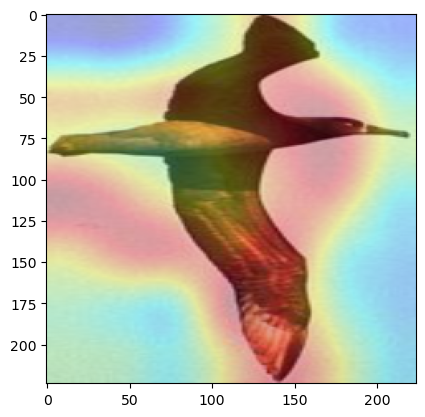

In [134]:
visualize_updated_prototype(a3c.PPnet_multi, 3, 2)

In [28]:
def visualize_img_pattern(p_dir, pid):
    img = skio.imread('./human_comparisons/feedback_images/'+p_dir+'/original_imgs/'+pid+'.png')
    img = sk.img_as_float(img)
    pattern = np.load('./human_comparisons/feedback_images/'+p_dir+'/patterns/'+pid+'.npy')
    heatmap = cv2.applyColorMap(np.uint8(255*pattern), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]
    overlayed_original_img = 2.0 * img[:, :, :3] + 1.0 * heatmap
    overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
    overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
    plt.imshow(overlayed_original_img)

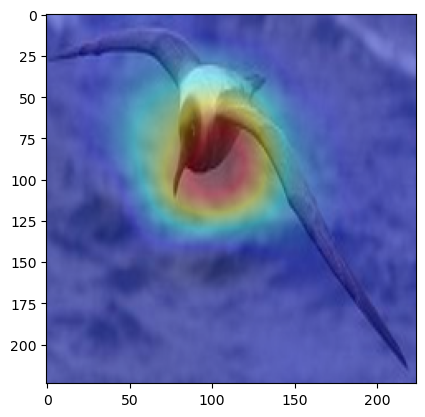

In [29]:
visualize_img_pattern('k=1_random', '89_0')

In [29]:
acc = tnt.test(model=a3c.PPnet_multi, dataloader=test_loader, class_specific=True, log=print)

	test


58it [00:45,  1.26it/s]


	time: 	46.16942882537842
	cross ent: 	7.195334227948353
	cluster: 	4.64465587843081
	separation:	0.0867374726924403
	avg separation:	9.372501044437803
	accu: 		15.878494994822228%
	l1: 		1273.353515625
	p dist pair: 	6.52275276184082
